# XGB Experiment based on 64 Variables 1911k Rows 14 Waves

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
!pip install seaborn

## Load and Make Datasets

In [4]:
Df_Filename = os.path.join("Data", "GallupWB_Ml64var1911k14wave_v1.parquet")

In [5]:
Df = pd.read_parquet(Df_Filename)

In [6]:
Df.shape

(1911212, 64)

### Train and Test df

In [7]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')

In [9]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Living_standard_change,Enough_food,Enough_shelter,Well_rested,Respected,...,Corruption_government,Performance_leadership,Gender_female,Age,Marital_status,Employment,Children_under15,Feeling_income,Income_level,COUNTRY_ISO3
0,10,35602.470662,7.0,2.0,1.0,-0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,64.0,1.0,5.0,0.0,2.0,3.0,NZL
1,11,20170.734058,5.0,2.0,1.0,-1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,18.0,1.0,6.0,0.0,2.0,1.0,LBN
2,6,8664.458086,4.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,15.0,1.0,6.0,1.0,3.0,3.0,BWA
3,12,30706.925977,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,33.0,2.0,1.0,1.0,2.0,1.0,KWT
4,7,4826.805232,8.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,29.0,8.0,1.0,1.0,3.0,4.0,HND


In [10]:
y = Df['Cantril_ladder']

In [11]:
X = Df.drop(columns=['Cantril_ladder'])

In [12]:
X.shape

(1911212, 63)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Basic XGBoost Experiment

In [14]:
model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                         n_estimators=500, learning_rate=0.01, max_depth=5, 
                         random_state=42, enable_categorical=True  )
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred = model.predict(X_test)

/home/linux/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:55:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [16]:
r2_score(y_test, y_pred) * 100

35.5966296143017

In [17]:
y_train_pred = model.predict(X_train)

In [18]:
r2_score(y_train, y_train_pred) * 100

35.76520229433162

### Fine-tune Hyperparameters

In [19]:
n_estimators_list = list(range(100, 1_100, 100))
learning_rate_list = [0.001, 0.01, 0.1]
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]

In [ ]:
results_list = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            for subsample in subsample_list:
                model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', 
                                         tree_method='hist', 
                                         n_estimators = n_estimators, 
                                         learning_rate = learning_rate, 
                                         max_depth = max_depth, 
                                         subsample = subsample,
                                         random_state=42, enable_categorical=True  )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                test_r2 = r2_score(y_test, y_pred) * 100
                y_train_pred = model.predict(X_train)
                train_r2 = r2_score(y_train, y_train_pred) * 100
                row = [n_estimators, learning_rate, max_depth, 
                       subsample, train_r2, test_r2]
                print(row)
                results_list.append(row)

[100, 0.001, 3, 0.6, 4.415129833618048, 4.422782984695772]
[100, 0.001, 3, 0.7, 4.412602303237378, 4.420117210903651]
[100, 0.001, 3, 0.8, 4.410935930442783, 4.41855089772758]
[100, 0.001, 3, 0.9, 4.4092220231562, 4.417050344741524]
[100, 0.001, 3, 1, 4.4095473873662865, 4.417731229417187]
[100, 0.001, 4, 0.6, 4.903044187677407, 4.912279482273075]


In [ ]:
gamma_list = [0, 0.01, 0.1, 1, 10]
min_child_weight_list = [0, 0.1, 1, 10]
max_delta_step_list = [0, 0.1, 1, 10]
reg_lambda_list = [0, 0.1, 1, 10]
reg_alpha_list = [0, 0.1, 1, 10]

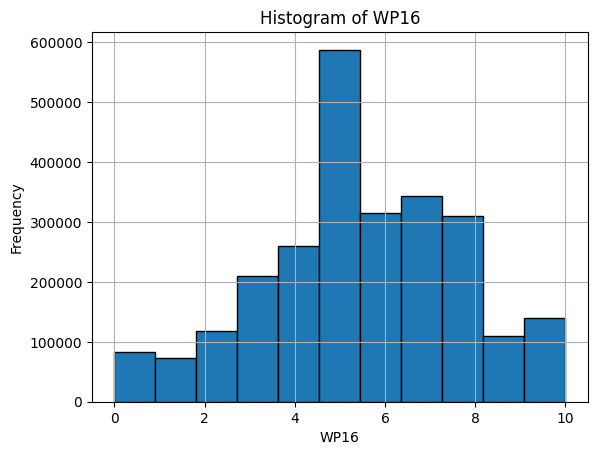

In [ ]:
plt.hist(RawDataset['WP16'], bins=11, range=(0, 10), edgecolor='black')
plt.title('Histogram of WP16')
plt.xlabel('WP16')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()